<a href="https://colab.research.google.com/github/aryamishra452/FER-using-different-ML-models/blob/main/VGG_16_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.IMPORT LIBRARIES

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


2.KAGGLE SETUP

In [3]:
from google.colab import drive, files
import os

# Mount Drive
drive.mount('/content/drive')

# Path where we’ll store kaggle.json forever
KAGGLE_PATH = "/content/drive/MyDrive/kaggle"

# Check if kaggle.json already exists in Drive
if not os.path.exists(f"{KAGGLE_PATH}/kaggle.json"):
    print("Upload kaggle.json (download from Kaggle > Account > Create API Token)")
    files.upload()  # upload kaggle.json once
    os.makedirs(KAGGLE_PATH, exist_ok=True)
    !cp kaggle.json {KAGGLE_PATH}/kaggle.json
    print("✅ Kaggle token saved to Drive!")
else:
    print("✅ Found kaggle.json in Drive")

# Copy to Colab's kaggle folder
!mkdir -p ~/.kaggle
!cp {KAGGLE_PATH}/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Mounted at /content/drive
✅ Found kaggle.json in Drive


3.DATASET DOWNLOAD

In [4]:
!kaggle datasets download -d msambare/fer2013 -p /content
!unzip -q /content/fer2013.zip -d fer2013_data


Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
  0% 0.00/60.3M [00:00<?, ?B/s]
100% 60.3M/60.3M [00:00<00:00, 997MB/s]


4.DATASET PREPARATION

In [5]:
IMG_SIZE = 224
BATCH = 64

train_ds = keras.utils.image_dataset_from_directory(
    "fer2013_data/train",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    label_mode="int"
)

test_ds = keras.utils.image_dataset_from_directory(
    "fer2013_data/test",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    label_mode="int"
)

# Validation split
val_size = int(0.1 * tf.data.experimental.cardinality(train_ds).numpy())
val_ds = train_ds.take(val_size)
train_ds = train_ds.skip(val_size)

# Normalize
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))


Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


5.BUILD VGG16 TL MODEL

In [6]:
def build_vgg16_tl():
    base = keras.applications.VGG16(include_top=False, weights="imagenet",
                                    input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base.trainable = False   # freeze base

    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(7, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(1e-4),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

model = build_vgg16_tl()
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

6.TRAIN CLASSIFIER HEAD

In [7]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=0.5,

        min_lr=1e-7,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        "best_vgg16_tl.keras",
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks
)



Epoch 1/50
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.2061 - loss: 1.9622
Epoch 1: val_accuracy improved from -inf to 0.27344, saving model to best_vgg16_tl.keras
405/405 ━━━━━━━━━━━━━━━━━━━━ 164s 340ms/step - accuracy: 0.2062 - loss: 1.9621 - val_accuracy: 0.2734 - val_loss: 1.7700 - learning_rate: 1.0000e-04
Epoch 2/50
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.2411 - loss: 1.8259
Epoch 2: val_accuracy improved from 0.27344 to 0.31463, saving model to best_vgg16_tl.keras
405/405 ━━━━━━━━━━━━━━━━━━━━ 130s 317ms/step - accuracy: 0.2412 - loss: 1.8258 - val_accuracy: 0.3146 - val_loss: 1.7319 - learning_rate: 1.0000e-04
Epoch 3/50
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.2707 - loss: 1.7692
Epoch 3: val_accuracy improved from 0.31463 to 0.33842, saving model to best_vgg16_tl.keras
405/405 ━━━━━━━━━━━━━━━━━━━━ 143s 321ms/step - accuracy: 0.2708 - loss: 1.7692 - val_accuracy: 0.3384 - val_loss: 1.7025 - learning_rate: 1.0000e-04
Epoch 4/50
405/4

7.FINE-TUNE LAST BLOCK

In [8]:
for layer in model.layers[1].layers:
    if layer.name.startswith("block5"):
        layer.trainable = True

model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history_ft = model.fit(train_ds,
                       validation_data=val_ds,
                       epochs=10,
                       callbacks=callbacks)


Epoch 1/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.4022 - loss: 1.5410
Epoch 1: val_accuracy improved from 0.41016 to 0.49432, saving model to best_vgg16_tl.keras
405/405 ━━━━━━━━━━━━━━━━━━━━ 170s 397ms/step - accuracy: 0.4023 - loss: 1.5408 - val_accuracy: 0.4943 - val_loss: 1.3539 - learning_rate: 1.0000e-05
Epoch 2/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.4815 - loss: 1.3685
Epoch 2: val_accuracy improved from 0.49432 to 0.51172, saving model to best_vgg16_tl.keras
405/405 ━━━━━━━━━━━━━━━━━━━━ 158s 386ms/step - accuracy: 0.4816 - loss: 1.3685 - val_accuracy: 0.5117 - val_loss: 1.2960 - learning_rate: 1.0000e-05
Epoch 3/10
405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.5103 - loss: 1.2990
Epoch 3: val_accuracy improved from 0.51172 to 0.52734, saving model to best_vgg16_tl.keras
405/405 ━━━━━━━━━━━━━━━━━━━━ 150s 367ms/step - accuracy: 0.5103 - loss: 1.2989 - val_accuracy: 0.5273 - val_loss: 1.2615 - learning_rate: 1.0000e-05
Epoch 4/10
40

8.VISUALIZATION

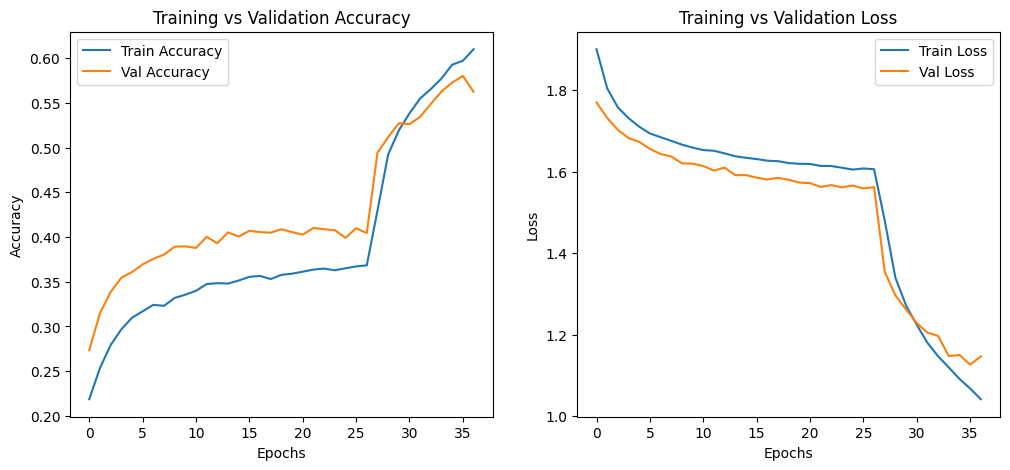

In [11]:
import matplotlib.pyplot as plt

# Combine histories from head training and fine-tuning
def combine_history(h1, h2):
    acc = h1.history['accuracy'] + h2.history['accuracy']
    val_acc = h1.history['val_accuracy'] + h2.history['val_accuracy']
    loss = h1.history['loss'] + h2.history['loss']
    val_loss = h1.history['val_loss'] + h2.history['val_loss']
    return acc, val_acc, loss, val_loss

acc, val_acc, loss, val_loss = combine_history(history, history_ft)

# Plot accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(acc, label="Train Accuracy")
plt.plot(val_acc, label="Val Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plot loss
plt.subplot(1,2,2)
plt.plot(loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


9.EVALUATE

In [12]:
best_model = keras.models.load_model("best_vgg16_tl.keras")
loss, acc = best_model.evaluate(test_ds)
print(f"Test Accuracy: {acc:.4f}")


113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 345ms/step - accuracy: 0.5626 - loss: 1.1405
Test Accuracy: 0.5804
